In [1]:
import os
import ast
import json
import joblib
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
results_dir = "HPC_code/rf_model_output_controls/results"  # Directory where the results files are stored
results_files = os.listdir(results_dir)  # List all the files in the directory

# Initialize an empty list to store the results
results_list = []

for file in results_files:
    # Construct the full path to the file
    file_path = os.path.join(results_dir, file)

    # Open the file and load the results into a dictionary
    # with open(file_path, 'r') as f:
    #     result_dict = json.load(f)

    # Read file contents 
    with open(file_path, 'r') as f:
        file_contents = f.read()

    if not file_contents.strip():
        print(f"Skipping empty file: {file_path}")
        continue
    # Convert string to dictionary
    try:
        result_dict = ast.literal_eval(file_contents)
    except SyntaxError as e:
        print(f"Error parsing file: {file_path}")
        print(e)

    # Split the filename at the underscore and extract the relevant parts
    file_parts = file.split("_")
    result_dict['field'] = file_parts[0]
    result_dict['year'] = file_parts[1]
    result_dict['soil_test'] = file_parts[2]
    result_dict['phosphorus_treatment'] = file_parts[3].split('.')[0]

    # Add the dictionary to the list
    results_list.append(result_dict)

# Load the results into a pandas DataFrame
df = pd.DataFrame(results_list)

In [3]:
print(df.shape)
df.head()

(120, 9)


,model_name,num_input_params,r2,mse,features_importances,field,year,soil_test,phosphorus_treatment
0,../rf_model_output_controls/models/16A_2018_H3...,22,0.389812,9.687350,"{'H3A_Al_0_2': 0.04512900061327653, 'H3A_Ca_0_...",16A,2018,H3A,np
1,../rf_model_output_controls/models/16A_2018_H3...,23,0.385005,9.763663,"{'H3A_Al_0_2': 0.04615748206232149, 'H3A_Ca_0_...",16A,2018,H3A,p
2,../rf_model_output_controls/models/16A_2018_M3...,22,0.418507,9.231784,"{'M3_Al_0_2': 0.05531443896500435, 'M3_Ca_0_2'...",16A,2018,M3,np
3,../rf_model_output_controls/models/16A_2018_M3...,23,0.423403,9.154062,"{'M3_Al_0_2': 0.04818846064298313, 'M3_Ca_0_2'...",16A,2018,M3,p
4,../rf_model_output_controls/models/16A_2018_Ol...,22,0.414300,9.298572,"{'Ols_Al_0_2': 0.03908594857520057, 'Ols_Ca_0_...",16A,2018,Ols,np


In [4]:
# Copy dataframe 
df2 = df.copy()

# Keys to remove
keys_to_remove = ['elevation', 'slope', 'aspect', 'TOC_0_2', 'TC_0_2', 'IC_0_2', 
                  'TN_0_2', 'TOC_2_6', 'TC_2_6', 'IC_2_6', 'TN_2_6','PhosphorusTreatment']

# Remove keys  
for i, row in df2.iterrows():
    for key in keys_to_remove:
        if key in row['features_importances']:
            del row['features_importances'][key]

# Sum importances into new list
summed_importances = []
for i, row in df2.iterrows():
    summed_importances.append(sum(row['features_importances'].values()))

# Create new column    
df2['soil_test_importances'] = summed_importances

# Confirm keys were removed
df2['features_importances'].iloc[0]

{'H3A_Al_0_2': 0.04512900061327653,
 'H3A_Ca_0_2': 0.03401439204003085,
 'H3A_Fe_0_2': 0.052323448409691796,
 'H3A_K_0_2': 0.07142099780055279,
 'H3A_Mg_0_2': 0.03335259551834733,
 'H3A_P_0_2': 0.056580212761794105,
 'H3A_Al_2_6': 0.11163324134560447,
 'H3A_Ca_2_6': 0.042131828042712184,
 'H3A_Fe_2_6': 0.13072397513352702,
 'H3A_K_2_6': 0.029419372948479783,
 'H3A_Mg_2_6': 0.03279306253745703,
 'H3A_P_2_6': 0.0563503974262349,
 'Zone_1': 0.015857217665432296,
 'Zone_2': 0.0,
 'Zone_3': 3.977363054266779e-05,
 'Zone_4': 0.01044882110109947}

In [5]:
# Reshape your data
pivot_df = df.pivot_table(index=['field', 'year', 'soil_test'], columns='phosphorus_treatment', values='r2')

# Subtract the 'np' values from the 'p' values
pivot_df['r2_diff'] = pivot_df['p'] - pivot_df['np']

# Reset the index to return the dataframe to a similar format as before
pivot_df = pivot_df.reset_index()

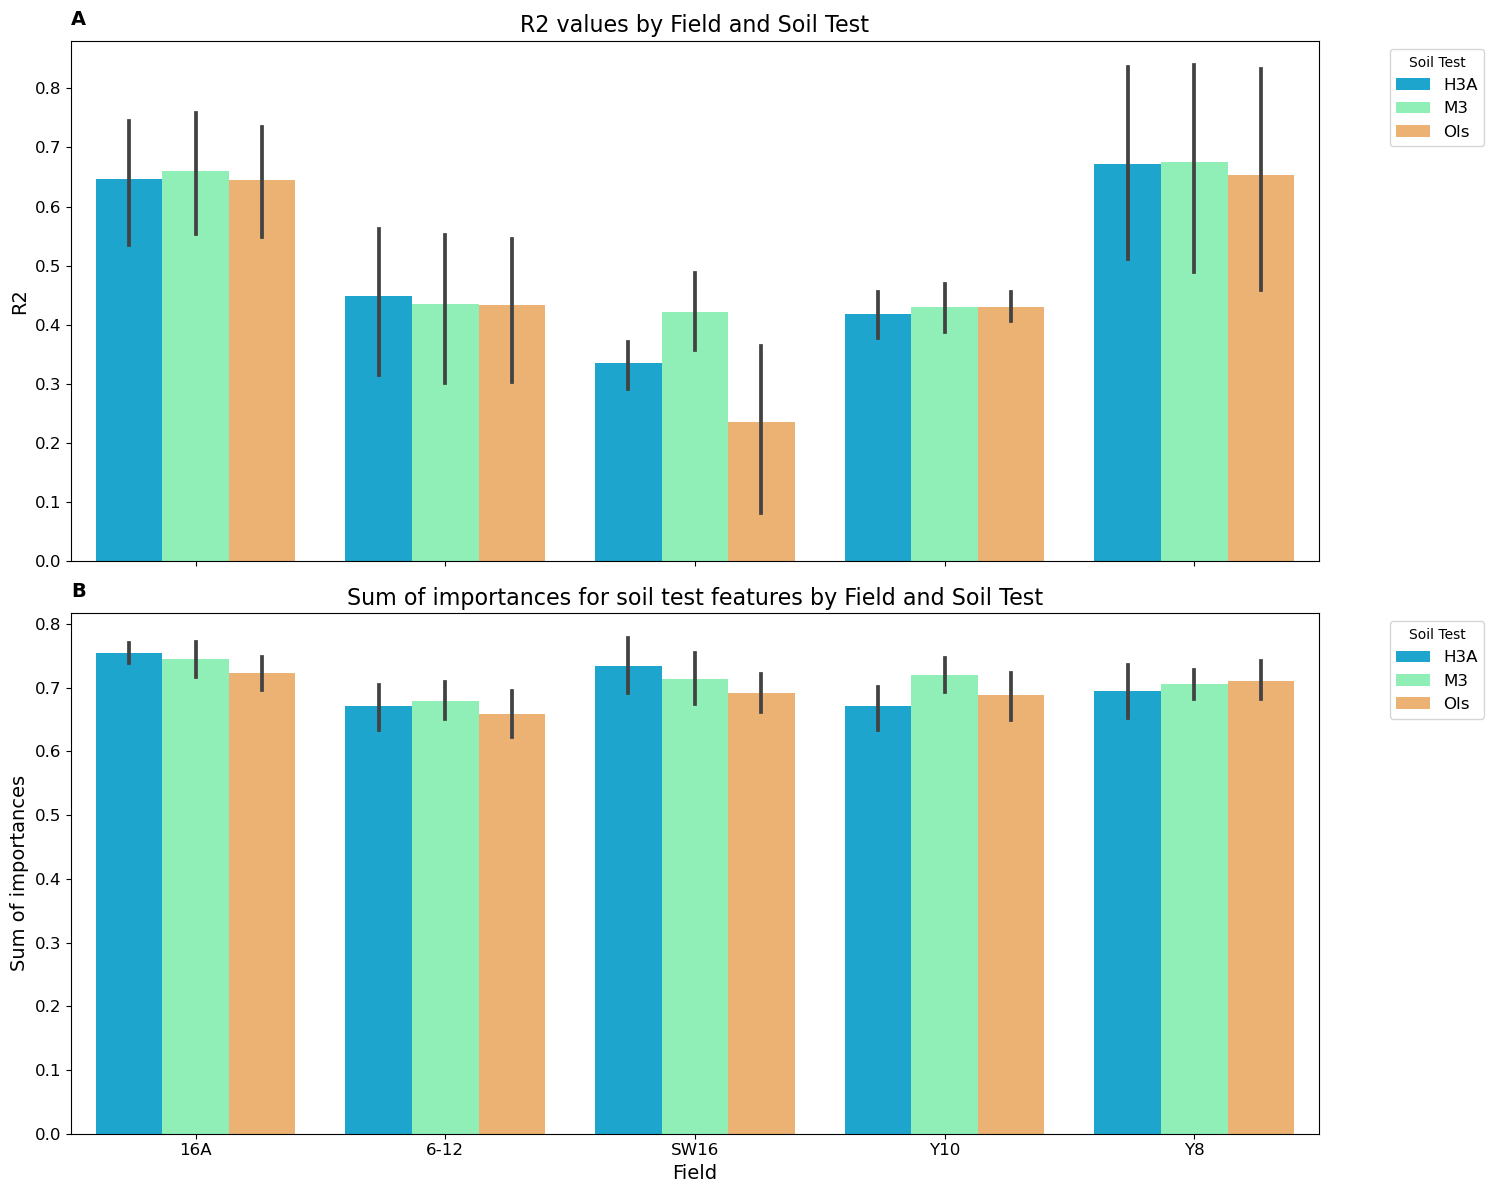

In [8]:
# Create figure and axes
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(15, 12), sharex=True)

# Plot 1 
sns.barplot(ax=ax1, data=df, x='field', y='r2', hue='soil_test', palette='rainbow')
ax1.set_title('R2 values by Field and Soil Test', fontsize=16)  # Increase title font size
ax1.set_ylabel('R2', fontsize=14)  # Increase Y axis label font size
ax1.legend(title='Soil Test', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)  # Increase legend font size
ax1.set_xlabel('')
ax1.tick_params(axis='both', which='major', labelsize=12)  # Increase tick label font size
ax1.text(0, 1.03, 'A', transform=ax1.transAxes, fontsize=14, fontweight='bold')

# Plot 2
sns.barplot(ax=ax2, data=df2, x='field', y='soil_test_importances', hue='soil_test', palette='rainbow')
ax2.set_title('Sum of importances for soil test features by Field and Soil Test', fontsize=16)  # Increase title font size
ax2.set_ylabel('Sum of importances', fontsize=14)  # Increase Y axis label font size
ax2.set_xticks(range(5))
# ax2.set_xticklabels(range(1,6))
ax2.legend(title='Soil Test', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)  # Increase legend font size
ax2.set_xlabel('Field', fontsize=14)  # Increase X axis label font size
ax2.tick_params(axis='both', which='major', labelsize=12)  # Increase tick label font size
ax2.text(0, 1.03, 'B', transform=ax2.transAxes, fontsize=14, fontweight='bold')

# Adjust layout 
fig.tight_layout()
plt.savefig('Output/Figures/Controls_RF_R2.jpg', bbox_inches='tight', dpi=300)

In [8]:
results_dir = "HPC_code/rf_model_output_controls/results"
models_dir = "HPC_code/rf_model_output_controls/models"
X_dir = "HPC_code/rf_model_output_controls/X"

# Load all results dicts
results = []
for file_path in os.listdir(results_dir):
    # print(file_path)
    with open(os.path.join(results_dir, file_path)) as f:
        results.append(json.load(f))

for result in results:

  # Extract model path
  model_path = result['model_name'].split('/')[-1]
  
  # Load model
  model = joblib.load(os.path.join(models_dir, model_path))
  result['model'] = model

  # Construct X_train path from model path
  x_train_path = model_path.replace('models', 'X').replace('joblib', 'csv')

  # Load X_train
  x_train = pd.read_csv(os.path.join(X_dir, x_train_path))
  result['X_train'] = x_train

In [9]:
len(results)

120

In [11]:
import matplotlib.patches as mpatches

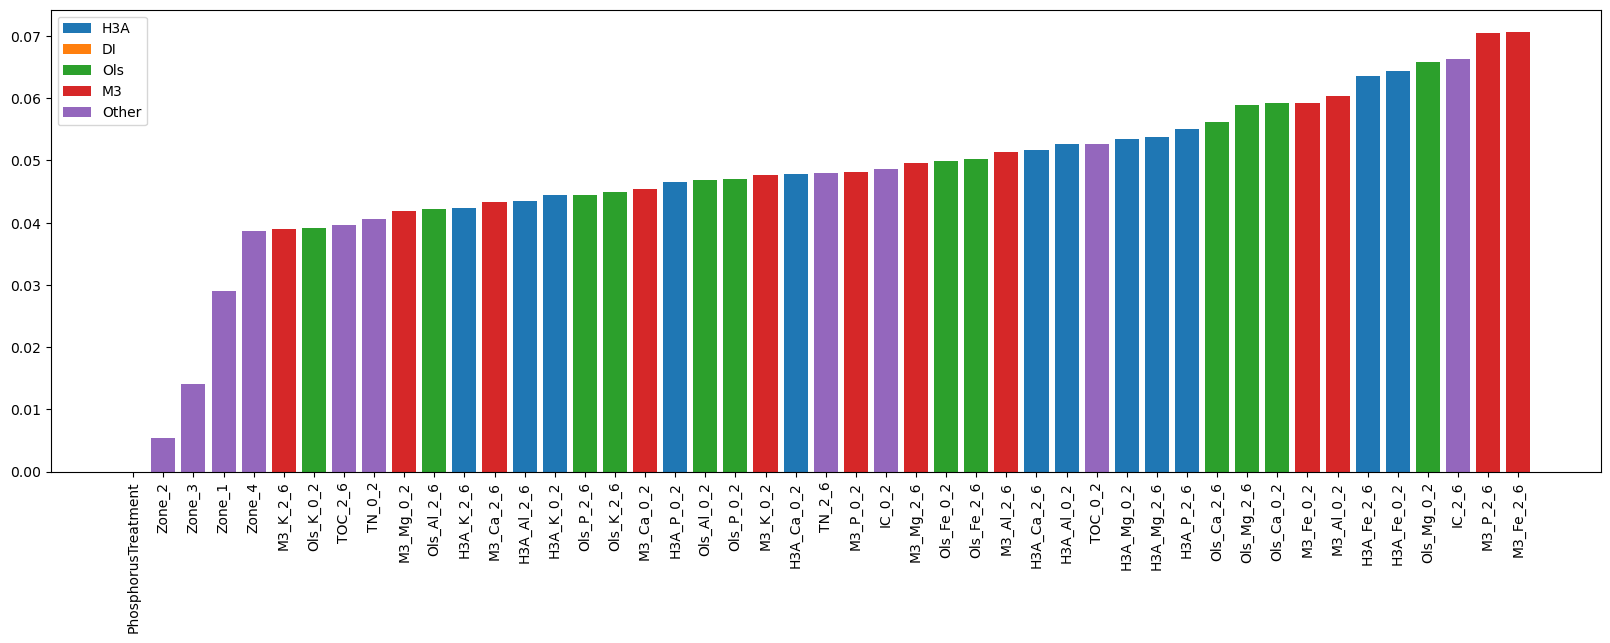

In [13]:
# Extract feature names
feature_names = set() 
for result in results:
    # print(result['model_name'])
    feature_names.update(result['features_importances'].keys())

# Initialize dicts
avg_importances = {f: 0 for f in feature_names}
feature_counts = {f: 0 for f in feature_names}

for result in results:

  for f, imp in result['features_importances'].items():
    
    # Increment count for this feature
    feature_counts[f] += 1
    
    # Add importance contribution
    avg_importances[f] += imp

# Calculate average based on counts 
for f in avg_importances:
  avg_importances[f] /= feature_counts[f] 

# Plot
# Sort the importances
sorted_importances = dict(sorted(avg_importances.items(), key=lambda x: x[1]))

# Get sorted keys and values 
feat_names = list(sorted_importances.keys())
importances = list(sorted_importances.values())

# Dictionary of colors 
color_map = {'H3A': 'C0', 'DI': 'C1', 'Ols': 'C2', 'M3': 'C3', 'Other': 'C4'} 

# Get colors for each bar
colors = []
for feat in feat_names:
    substring = feat.split('_')[0]
    if substring in color_map:
        colors.append(color_map[substring])
    else:
        colors.append(color_map['Other'])

fig, ax = plt.subplots(figsize=(20, 6))

# Plot bars
plt.bar(range(len(importances)), importances, color=colors)

# Set xtick labels  
plt.xticks(range(len(feat_names)), feat_names, rotation=90)

# Legend
legend_elements = [mpatches.Patch(facecolor=color_map[x], label=x) for x in color_map]
plt.legend(handles=legend_elements)
plt.savefig('Output/Figures/All_control_feature_importances.jpg', bbox_inches = 'tight', dpi = 300)